## Pendulum simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import pydae.svg_tools as svgt
%config InlineBackend.figure_format = 'svg'
plt.ion()

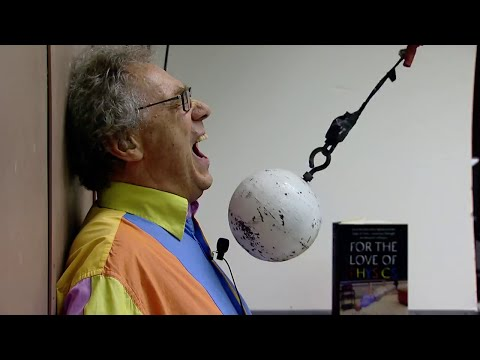

In [2]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('4a0FbQdH3dY')

- **Test 1**: At 9:43 Walter sets the bom at 5º               (How much force in x did he applied?)
- **Test 2**: At 11:35 he sets the bom in 10º (How much force in x did he applied?)
- **Test 3**: At 16:20 he changes the mass sitting over the bom
- **Test 4**: At 24:42 he applied a little push and the glass results broken   
- Also but not tested 24:00 without little push 26:50 dangerous experiment

Before simulating we need to import the class from the build module:

In [3]:
from pydae import ssa
import pendulum

Then you can create an instance of the class:

In [4]:
p_0 = pendulum.model()

### Initialization

The `ini` method gives the steady state of the system by solving first the backward and then the forward problems.
In this case 

In [5]:
M = 30.0  # mass of the bob (kg)
L = 5.21  # length of the pendulum (m)
p_0.ini({
                 'M':M,'L':L,           # parameters setting
                 'theta':np.deg2rad(0)  # initial desired angle = 0º
                },-1)                  # here -1 means that -1 is considered as initial gess for
                                        # dynamic and algebraic states


True

Once the system is initialized we can show the obtained variable values:

In [6]:
p_0.report_x()  # obtained dynamic states
p_0.report_y()  # obtained algebraic states
p_0.report_z()  # obtained outputs
p_0.report_u()  # obtained algebraic states (theta is both state and output; f_x is both input and output)
p_0.report_params()  # considered parameters

p_x   =  0.00
p_y   = -5.21
v_x   =  0.00
v_y   =  0.00
lam   = 28.24
theta =  0.00
E_p   = -0.00
E_k   =  0.00
f_x   = -0.00
f_x   =-0.00
L     = 5.21
G     = 9.81
M     =30.00
K_d   = 0.00


Another option to get values is to use the `get_value` method. Let's use it and then calculate the oscillation period of the pendulum as:

$$ 
T = 2\pi \sqrt{\frac{L}{G}}
$$

In [7]:
G = p_0.get_value('G')
L = p_0.get_value('L')

T = 2*np.pi*np.sqrt(L/G)

print(f'Oscillation period with formula: T = {T:0.2f} s')

Oscillation period with formula: T = 4.58 s


### Small signal analisys

After the system is initialized we can perform a small signal analysis. The `pydae.ssa` module has a method called `eval_A` to compute the matrix $A$ for the system:

$$
\Delta \mathbf{\dot {x}} = \mathbf{A}\Delta \mathbf{x}  
$$

In [8]:
ssa.A_eval(p_0)              # method to linealized the system and to compute matrix A
eig_df=ssa.damp_report(p_0)  # method to create a pandas.DataFrame after computing eigenvalues for A
eig_df

,Real,Imag,Freq.,Damp
Mode 1,-0.000017,1.372194,0.218391,1.214600e-05
Mode 2,-0.000017,-1.372194,0.218391,1.214600e-05
Mode 3,-0.000017,1902.424501,302.780263,8.760751e-09
Mode 4,-0.000017,-1902.424501,302.780263,8.760751e-09


Using mode analysis the period of the pendulum can be computes choosing the third mode **Mode 1**:

In [9]:
freq = eig_df['Freq.']['Mode 1']   # frequency of Mode 3 (Hz)
period = 1/freq                    # oscillation period
print(f'Oscillation period from small signal analysis: T = {period:0.2f} s')

Oscillation period from small signal analysis: T = 4.58 s


### Simulations

A time simulation can be performed using the method `sim`:


#### Test 1: Bom with initial angle of -5º

In [10]:
p_5 = pendulum.model()
p_5.ini({'M':M,'L':L,'theta':np.deg2rad(-5)},-1)      # initilize the system with theta = -5º and run until t=1s
p_5.run(50.0,{'f_x':0.0})                 # release the pendulum by making the f_x force equal zero       
p_5.post()                                # here the initialization is using the previous computed
                                          # steady state 

Oscillation period from simulation: T = 4.58 s


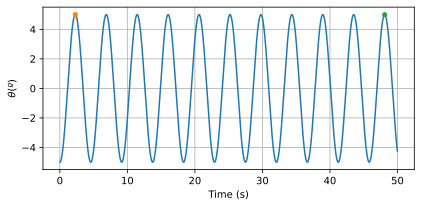

In [11]:
time = p_5.Time                              # gets the simulated times
theta = np.rad2deg(p_5.get_values('theta'))  # gets the values for theta (and covert them from rad to deg)

# this is just to find the period of the theta oscillation:
idx_1 = np.where(theta==np.max(theta[(time>0)&(time<7)]))[0][0]     
idx_2 = np.where(theta==np.max(theta[(time>45)&(time<50)]))[0][0]
t_1 = time[idx_1]
t_2 = time[idx_2]

period_sim = t_2 - t_1

print(f'Oscillation period from simulation: T = {period_sim/10:0.2f} s')

# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(p_5.Time, np.rad2deg(p_5.get_values('theta')), label=f'$\theta$')
axes.plot(t_1, np.rad2deg(p_5.get_values('theta')[idx_1]),'o',ms=4)
axes.plot(t_2, np.rad2deg(p_5.get_values('theta')[idx_2]),'o',ms=4)
axes.grid()
axes.set_ylabel('$\\theta (º)$')
axes.set_xlabel('Time (s)')
fig.tight_layout()



##### Animation of the results

The obtained results can be animated. 

In [14]:
from importlib import reload  
reload(svgt)
import pydae.rdp as rdp

times = p_5.Time
x_orig = p_5.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.002) 
times_r = reduced[:,0]

theta = np.interp(times_r,times,-np.rad2deg(p_5.get_values('theta')))  
x =  np.interp(times_r,times,x_orig)
y =  np.interp(times_r,times,-10*(5.21+p_5.get_values('p_y')))
f_x = np.interp(times_r,times,-p_5.get_values('f_x')*0.05)

anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_1'
anim.translate(np.array([0.,3.]),np.array([0.0,0.0]),np.array([0.0,0.0]))

# pendulum: layer translate(-60.723018,-69.096172), center: 47.589,-142.050
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = ''
anim.begin = 'play_1.begin'
anim.rotate(times_r,theta,73.327,31.538)

# force:
anim.group_id = 'f_x_pos'
anim.begin = 'play_1.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,72.019669,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_1.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,74.635086,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.save('pendulum_5deg.svg')


In [ ]:
HTML('pendulum_5deg.svg')

#### Test 2: Bom with initial angle of -10º


Let's supposed that we want to show that the period depends very little on the amplitude (if we consider a small one). Now we can simulate like in the previous case but with an initial angle of 10º and then compare the results:

In [15]:
p_10 = pendulum.model()
M = 30.0
L = 5.21

p_10.ini({'f_x':0,'M':M,'L':L,'theta':np.deg2rad(-10)},-1)
p_10.run(50.0,{'f_x':0})
p_10.post();

In [16]:
times = p_5.Time
x_orig = p_5.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.002) 
times_r_5 = reduced[:,0]

theta_5 = np.interp(times_r_5,times,-np.rad2deg(p_5.get_values('theta')))  
x_5 =  np.interp(times_r_5,times,x_orig)
y_5 =  np.interp(times_r_5,times,-10*(5.21+p_5.get_values('p_y')))
f_x_5 = np.interp(times_r_5,times,-p_5.get_values('f_x')*0.05)

times = p_10.Time
x_orig = p_10.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.002) 
times_r_10 = reduced[:,0]

theta_10 = np.interp(times_r_10,times,-np.rad2deg(p_10.get_values('theta'))) 
x_10 =  np.interp(times_r_10,times,x_orig)
y_10 =  np.interp(times_r_10,times,-10*(5.21+p_10.get_values('p_y')))
f_x_10 = np.interp(times_r_10,times,-p_10.get_values('f_x')*0.05)


anim = svgt.animatesvg('../svg/pendulum_2.svg','pendulum_1')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_anim_2'
anim.scale(np.array([0,1.0]),np.array([1.,1.]),np.array([1.,1.]),np.array([1.,1.]),np.array([1.,1.0]))
anim.anim_id = ''

# pendulums:
anim.group_id = 'pendulum_1'
anim.begin_click = False
anim.begin = 'play_anim_2.begin'

anim.rotate(times_r_5,theta_5,73.327,31.538)
anim.group_id = 'pendulum_2'
anim.rotate(times_r_10,theta_10,73.327,31.538)

anim.save('pendulum_5deg_10deg.svg')


In [ ]:
HTML('pendulum_5deg_10deg.svg')

#### Test 3

Now we can make a simulation considering Walter over the bom. This means that the mass is changed from 30 kg to 30+75 = 105 kg.

In [18]:
p_m105 = pendulum.model()

p_m105.ini({'f_x':0,'M':30+75,'L':L,'theta':np.deg2rad(0)},-0.1)

ssa.A_eval(p_m105)

eig_df_m105 = ssa.damp_report(p_m105)

In [19]:
freq_m30 = eig_df['Freq.']['Mode 1']   # frequency of Mode 1 (Hz)
freq_m105 = eig_df_m105['Freq.']['Mode 1']   # frequency of Mode 1 (Hz)

print(f'Oscillation period from small signal analysis with M = 30 kg:  T = {1/freq_m30:0.2f} s')
print(f'Oscillation period from small signal analysis with M = 105 kg: T = {1/freq_m105:0.2f} s')

Oscillation period from small signal analysis with M = 30 kg:  T = 4.58 s
Oscillation period from small signal analysis with M = 105 kg: T = 4.58 s


As we can see with the small signal analysis the oscilation period does not change with the mass. Now we can simulate to verify the result in time domain.

In [20]:
p_m105.ini({'f_x':0,'M':105,'L':L,'theta':np.deg2rad(-10)},-1)
p_m105.run(50.0,{'f_x':0})
p_m105.post();

In [21]:
from importlib import reload  
reload(svgt)
import pydae.rdp as rdp

times = p_m105.Time
x_orig = p_m105.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.002) 
times_r = reduced[:,0]

theta = np.interp(times_r,times,-np.rad2deg(p_m105.get_values('theta')))  
x =  np.interp(times_r,times,x_orig)
y =  np.interp(times_r,times,-10*(5.21+p_m105.get_values('p_y')))
f_x = np.interp(times_r,times,-p_m105.get_values('f_x')*0.05)

anim = svgt.animatesvg('../svg/pendulum_105kg_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_105'
anim.translate(np.array([0.,3.]),np.array([0.0,0.0]),np.array([0.0,0.0]))

# pendulum:
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = ''
anim.begin = 'play_105.begin'
anim.rotate(times_r,theta,73.327,31.538)

# force:
anim.group_id = 'f_x_pos'
anim.begin = 'play_105.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,72.019669,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_105.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,74.635086,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.save('pendulum_105kg.svg')


In [ ]:
HTML('pendulum_105kg.svg')

#### Test 4

Now we can make a simulation considering Walter over the bom. This means that the mass is changed from 30 kg to 30+75 = 105 kg.

In [22]:
pend_push =  pendulum.model()
pend_push.ini({'f_x':0,'M':30,'L':L,'theta':np.deg2rad(-10)},-1)

pend_push.run( 0.5,{'f_x':20.0})  # initilize the system with theta = -5º and run until t=1s
pend_push.run(10.0,{'f_x': 0.0})  # release the pendulum by but applying a positive force equal
                                  # release the pendulum
pend_push.post();                            

In [23]:
times = pend_push.Time
x_orig = pend_push.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.001) 
times_r = reduced[:,0]

theta = np.interp(times_r,times,-np.rad2deg(pend_push.get_values('theta')))  
x =  np.interp(times_r,times,x_orig)
y =  np.interp(times_r,times,-10*(5.21+pend_push.get_values('p_y')))
f_x = np.interp(times_r,times,-pend_push.get_values('f_x')*0.05)

anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_3'
anim.translate(np.array([0.,3.]),np.array([0.0,0.0]),np.array([0.0,0.0]))

# pendulum:
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = ''
anim.begin = 'play_3.begin'
anim.rotate(times_r,theta,73.327,31.538)

# force:
anim.group_id = 'f_x_pos'
anim.begin = 'play_3.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,72.019669,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_3.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,74.635086,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.save('pendulum_10deg_push.svg')



In [ ]:
HTML('pendulum_10deg_push.svg')

#### Control

##### Simulation for control testing

In [26]:
Δt = 0.1
p_ctrl = pendulum.model()
times = np.arange(0,30,Δt)
p_ctrl.ini({'M':30,'L':5.21,'theta':np.deg2rad(-10)},-1)

f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x = f_x_0
    if t>2.0:
        f_x = 0.0
    p_ctrl.run(t,{'f_x':f_x})
    
p_ctrl.post();


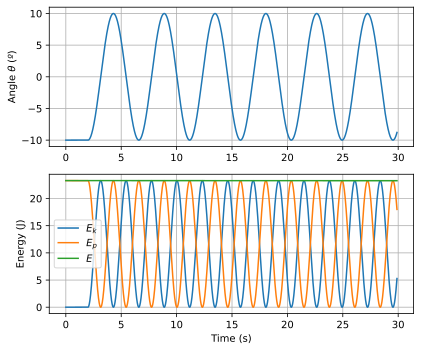

In [27]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(p_ctrl.Time, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')
E_k = p_ctrl.get_values('E_k')
E_p = p_ctrl.get_values('E_p')
axes[1].plot(p_ctrl.Time, E_k, label=f'$E_k$')
axes[1].plot(p_ctrl.Time, E_p, label=f'$E_p$')
axes[1].plot(p_ctrl.Time, E_k+E_p, label=f'$E$')

axes[0].grid()
axes[1].grid()
axes[1].legend()
axes[0].set_ylabel('Angle $\\theta\; (º)$')
axes[1].set_ylabel('Energy (J)')
axes[1].set_xlabel('Time (s)')
fig.tight_layout()


##### Basic porportional regulator

Now we are going to propose a control law as follows:

$$
\Delta f_x = - K v_x
$$

$$
f_x = f_h + \Delta f_x 
$$

where $f_x$ is the hand effort and $\Delta f_x$ is the controller force increment.

In [35]:
Δt = 0.1
p_ctrl = pendulum.model()
times = np.arange(0,25,Δt)
p_ctrl.ini({'M':30,'L':5.21,'theta':np.deg2rad(-10)},-1)

K = 20.0
f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x_hand = f_x_0
    if t>2.0:
        f_x_hand = 0.0
    
    v_x = p_ctrl.get_value('v_x')        # speed in x measurement
     
    f_x = f_x_hand - K*v_x            # control law
    
    p_ctrl.run(t,{'f_x':f_x})  # simulation until t(k+1) =  Δt + t(k) with the updated f_x force 
    
p_ctrl.post();  # required post processing


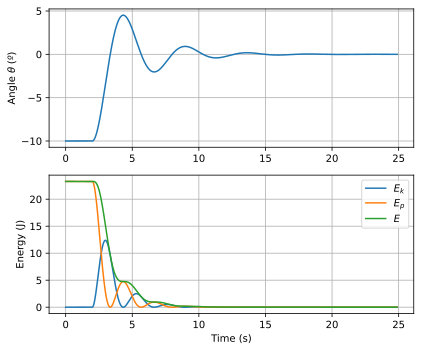

In [36]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(p_ctrl.Time, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')
E_k = p_ctrl.get_values('E_k')
E_p = p_ctrl.get_values('E_p')
axes[1].plot(p_ctrl.Time, E_k, label=f'$E_k$')
axes[1].plot(p_ctrl.Time, E_p, label=f'$E_p$')
axes[1].plot(p_ctrl.Time, E_k+E_p, label=f'$E$')

axes[0].grid()
axes[1].grid()
axes[1].legend()
axes[0].set_ylabel('Angle $\\theta\; (º)$')
axes[1].set_ylabel('Energy (J)')
axes[1].set_xlabel('Time (s)')
fig.tight_layout()

In [37]:
times = p_ctrl.Time
x_orig = p_ctrl.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.0001) 
times_r = reduced[:,0]

theta = np.interp(times_r,times,-np.rad2deg(p_ctrl.get_values('theta')))  
x =  np.interp(times_r,times,x_orig)
y =  np.interp(times_r,times,-10*(5.21+p_ctrl.get_values('p_y')))
f_x = np.interp(times_r,times,-p_ctrl.get_values('f_x')*0.05)

anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_4'
anim.translate(np.array([0.,3.]),np.array([0.0,0.0]),np.array([0.0,0.0]))

# pendulum:
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = ''
anim.begin = 'play_4.begin'
anim.rotate(times_r,theta,73.327,31.538)

# force:
anim.group_id = 'f_x_pos'
anim.begin = 'play_4.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,72.019669,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_4.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,74.635086,83.537544,s_x,s_y)
anim.translate(times_r,x,y)


anim.save('pendulum_ctrl.svg')


In [ ]:
HTML('pendulum_ctrl.svg')

##### On-off control

In [38]:
Δt = 0.1
p_ctrl = pendulum.model()
times = np.arange(0,25,Δt)
p_ctrl.ini({'M':30,'L':5.21,'theta':np.deg2rad(-10)},-1)

K = 20.0
f_x_0 = p_ctrl.get_value('f_x')
for t in times:
    f_x_hand = f_x_0
    if t>2.0:
        f_x_hand = 0.0
    
    p_x = p_ctrl.get_value('p_x')        # position in x measurement
    v_x = p_ctrl.get_value('v_x')        # speed in x measurement
     
    f_x = f_x_hand - np.sign(v_x)*5            # control law
    
    p_ctrl.run(t,{'f_x':f_x})  # simulation until t(k+1) =  Δt + t(k) with the updated f_x force 
    
p_ctrl.post();  # required post processing

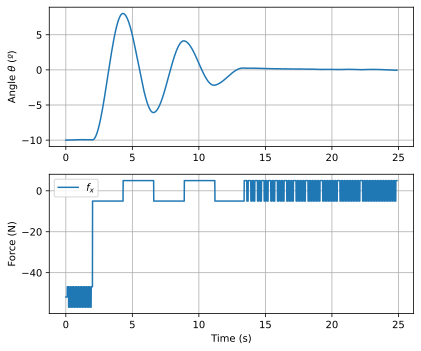

In [39]:
# plotting the results with matplolib:
plt.close('all')
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(p_ctrl.Time, np.rad2deg(p_ctrl.get_values('theta')), label=f'$\theta$')
axes[1].plot(p_ctrl.Time, p_ctrl.get_values('f_x'), label=f'$f_x$')


axes[0].grid()
axes[1].grid()
axes[1].legend()
axes[0].set_ylabel('Angle $\\theta\; (º)$')
axes[1].set_ylabel('Force (N)')
axes[1].set_xlabel('Time (s)')

fig.tight_layout()

In [40]:

times = p_ctrl.Time
x_orig = p_ctrl.get_values('p_x')*10
orig = np.vstack((times,x_orig)).T
reduced = rdp.rdp(orig,epsilon=0.001) 
times_r = reduced[:,0]

theta = np.interp(times_r,times,-np.rad2deg(p_ctrl.get_values('theta')))  
x =  np.interp(times_r,times,x_orig)
y =  np.interp(times_r,times,-10*(5.21+p_ctrl.get_values('p_y')))
f_x = np.interp(times_r,times,-p_ctrl.get_values('f_x')*0.05)

anim = svgt.animatesvg('../svg/pendulum_1_fx.svg','pendulum')
anim.set_size(600,400)

# start button:
anim.begin_click = True
anim.group_id = 'play'
anim.anim_id = 'play_5'
anim.translate(np.array([0.,3.]),np.array([0.0,0.0]),np.array([0.0,0.0]))

# pendulum:
anim.group_id = 'pendulum'
anim.begin_click = False
anim.anim_id = ''
anim.begin = 'play_5.begin'
anim.rotate(times_r,theta,73.327,31.538)

# force:
anim.group_id = 'f_x_pos'
anim.begin = 'play_5.begin'
s_x = -np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,72.019669,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.group_id = 'f_x_neg'
anim.begin = 'play_5.begin'
s_x = np.copy(f_x)
s_x[s_x<0] = 0.0
s_y = s_x
anim.scale(times_r,74.635086,83.537544,s_x,s_y)
anim.translate(times_r,x,y)

anim.save('pendulum_ctrl_on_off.svg')


In [ ]:
HTML('pendulum_ctrl_on_off.svg')

### Description
    
    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.
    ### Action Space
    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.
     
| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |
    
**Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

### Observation Space

The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|---------------------|-------------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

**Note:** While the ranges above denote the possible values for observation space of each element,
        it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
-  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates
   if the cart leaves the `(-2.4, 2.4)` range.
-  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
       if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)
### Rewards
Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken,
including the termination step, is allotted. The threshold for rewards is 475 for v1.
### Starting State
All observations are assigned a uniformly random value in `(-0.05, 0.05)`
### Episode End
The episode ends if any one of the following occurs:
1. Termination: Pole Angle is greater than ±12°
2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500 (200 for v0)
### Arguments
```
gym.make('CartPole-v1')
```
No additional arguments are currently supported.